# WSO Retention Model
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* May 18, 2022

This notebook provides example code of how to execute a RedShift stored procedure and get a result set back by connecting to the RedShift db directly using the psycodb2 package. The data and databases used are for demonstration purposes only:

In [12]:
import boto3
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

from pycaret.classification import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### To connect to RedShift, we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [2]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

BNSZ-FNCF
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


### Now we can create a session and client to RedShift (QA), and create a new connection using Psycopg2:

In [4]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'qa-app'
DBNAME = 'stlrwso'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: qa-app stlrwso


### First we need to call the stored procedure, which will create a named cursor - then we can query the results produced by the stored proc using that named cursor:

In [5]:
# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

cur = conn.cursor()
cur.execute(f"CALL dw.getretentionmodeldata(14, 2010, 2021, 'rkcursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('rkcursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [7]:
df.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,disttovenue,recency,missed_games_1,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer
0,14,296599068,2016,Full Series,551.28,1970-01-01,0.63,243,8760,251,27.34,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,1
1,14,296602184,2016,Full Series,2627.60,1970-01-01,0.57,255,8760,263,33.17,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,1
2,14,296601800,2016,Full Series,100.00,1970-01-01,0.47,255,7665,263,159.39,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,1
3,14,277993208,2016,Full Series,100.00,1970-01-01,0.47,211,2555,219,389.81,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,0
4,14,278079621,2016,Full Series,100.00,1970-01-01,1.00,269,3650,277,19.16,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12251 entries, 0 to 12250
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   lkupclientid         12251 non-null  int64         
 1   dimcustomermasterid  12251 non-null  int64         
 2   year                 12251 non-null  int64         
 3   productgrouping      12251 non-null  object        
 4   totalspent           12251 non-null  float64       
 5   recentdate           12251 non-null  datetime64[ns]
 6   attendancepercent    12251 non-null  float64       
 7   renewedbeforedays    12251 non-null  int64         
 8   source_tenure        12251 non-null  object        
 9   tenure               12251 non-null  int64         
 10  disttovenue          12251 non-null  float64       
 11  recency              12251 non-null  int64         
 12  missed_games_1       12251 non-null  object        
 13  missed_games_2       12251 non-

### We should specify the features used in our model:

In [10]:
# choose the features for the stellar base retention model
features = [
                "dimcustomermasterid",
                "attendancepercent",
                "disttovenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalspent",
                "recency",
                "source_tenure",
                "renewedbeforedays",
                "isnextyear_buyer",
                "productgrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8376, 13)
Unseen Data For Predictions: (1478, 13)



/var/folders/1z/ymtyx_zx7r168ctyc23cfmbh0000gn/T/ipykernel_11930/2048080078.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset["year"] = pd.to_numeric(df_dataset["year"])


### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [13]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimcustomermasterid","productgrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
                "attendancepercent",
                "disttovenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalspent",
                "recency",
                "source_tenure",
                "renewedbeforedays"
    ]
);

In [14]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8126,0.8860,0.7729,0.7992,0.7854,0.6192,0.6199,0.3640
lr,Logistic Regression,0.7265,0.8018,0.7150,0.6836,0.6988,0.4486,0.4491,0.3300


In [15]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8357,0.9086,0.7848,0.8350,0.8091,0.6651,0.6661
1,0.8048,0.8736,0.7880,0.7757,0.7818,0.6052,0.6053
2,0.8343,0.9125,0.8196,0.8094,0.8145,0.6647,0.6648
3,0.8048,0.8848,0.7911,0.7740,0.7825,0.6054,0.6056
4,0.7963,0.8705,0.7595,0.7767,0.7680,0.5866,0.5867
5,0.7992,0.8732,0.7563,0.7836,0.7697,0.5917,0.5920
6,0.8020,0.8732,0.7247,0.8092,0.7646,0.5946,0.5973
7,0.8301,0.9030,0.7722,0.8328,0.8013,0.6532,0.6546
8,0.8188,0.8782,0.7855,0.8032,0.7943,0.6324,0.6326
9,0.8003,0.8826,0.7468,0.7919,0.7687,0.5933,0.5940


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [17]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2397, 23)

In [18]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,...,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer,Label,Score_0,Score_1
1352,14,296599241,2021,Full Series,2200.00,2021-08-16,0.47,200,2190,1864,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.9374,0.0626
1419,14,296599091,2021,Full Series,2500.00,1970-01-01,0.53,206,2920,2099,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.9590,0.0410
1420,14,296598465,2021,Full Series,10500.00,1970-01-01,0.88,200,8760,2083,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.9740,0.0260
1421,14,296599314,2021,Full Series,7800.00,2021-08-20,0.70,205,8395,2084,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.7890,0.2110
1422,14,296599066,2021,Full Series,5500.16,1970-01-01,0.93,207,1095,913,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.9942,0.0058


In [19]:
new_predictions["Label"].value_counts()

0    2324
1      73
Name: Label, dtype: int64

In [20]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    1989
(0.2, 0.4]        278
(0.4, 0.6]         95
(0.6, 0.8]         31
(0.8, 1.0]          4
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

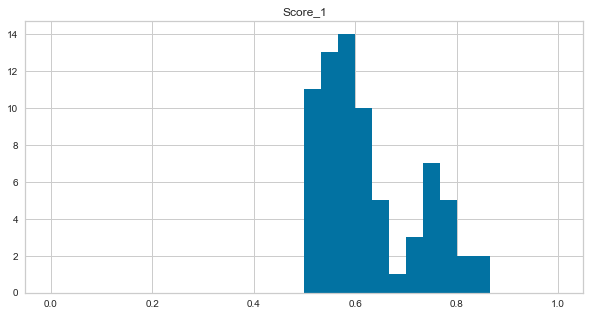

In [21]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_0'}>]], dtype=object)

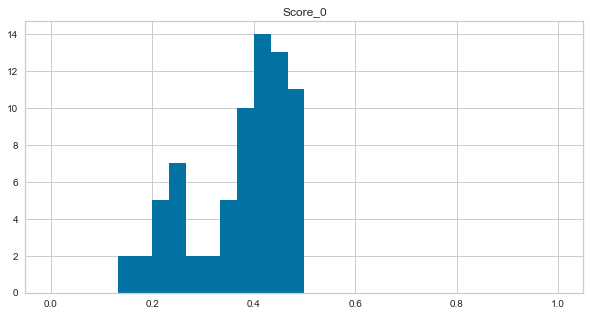

In [22]:
new_predictions[new_predictions["Label"]==1][["Score_0"]].hist(bins=30, figsize=(10,5), range=[0,1])

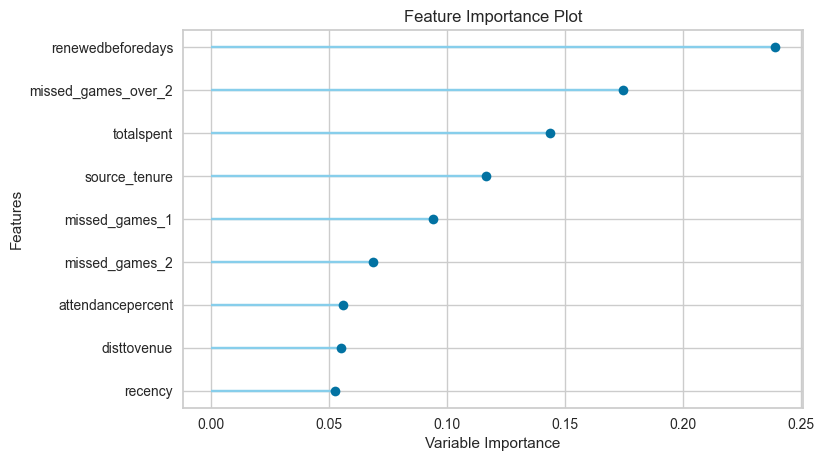

In [23]:
plot_model(best_model, plot='feature')

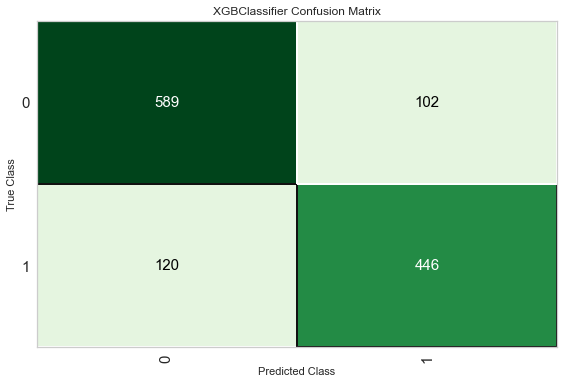

In [24]:
plot_model(best_model, plot='confusion_matrix')